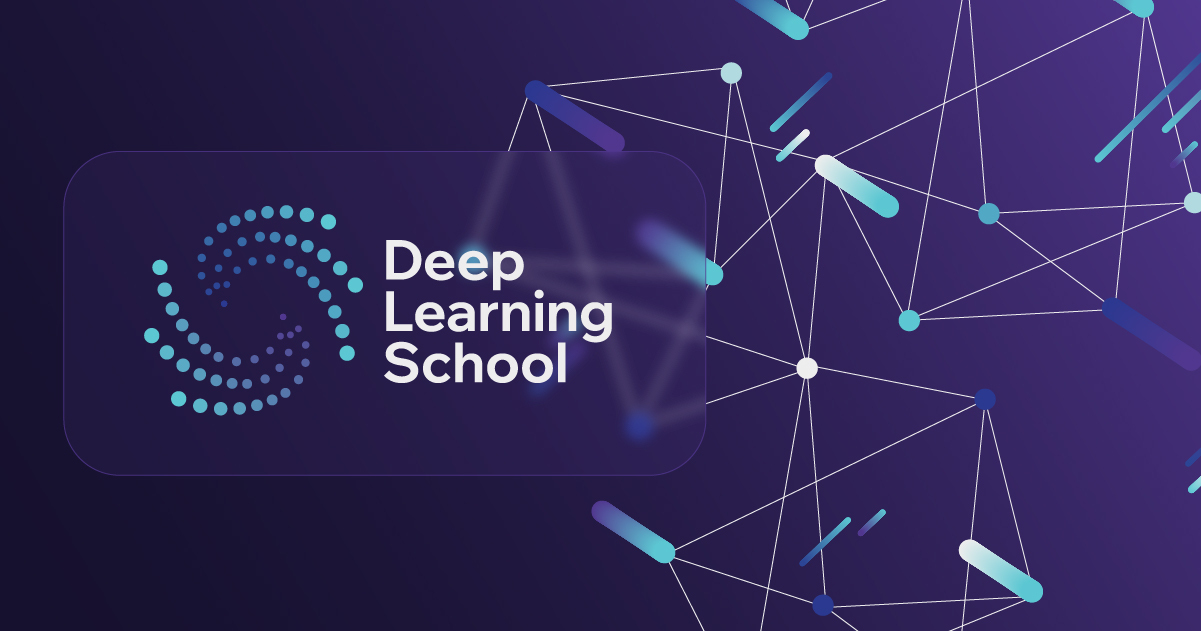


# Домашнее задание "Варианционные автоэнкодеры"

В этом домашнем задании вам предстоит реализовать несколько версий автоэнкодера для работы с изображениями.

Вы научитесь добавлять улыбку на фотографии людей, изменяя их исходное выражение лица с помощью обученной модели. А также, обучите ваш автоэнкодер генерировать изображения рукописных цифр.

# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (1 балл)


Перед тем, как начинать работу с моделями нужно подготовить данные.

In [1]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt

import os
import pandas as pd
import skimage.io
from skimage.transform import resize

import imageio
from PIL import Image
import kagglehub

In [2]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from IPython.display import clear_output
from torchvision import transforms

В этом задании вам предстоить работать с датасетом [LFW (Labeled Faces in the Wild)](https://datasets.activeloop.ai/docs/ml/datasets/lfw-dataset/#:~:text=What%20is%20LFW%20Dataset%3F,commercial%20algorithms%20prior%20to%20release).

In [3]:
# # Скачиваем картинки
# images_path = kagglehub.dataset_download("jessicali9530/lfw-dataset")
# print("Path to dataset files:", images_path)

In [4]:
# # Скачиваем атрибуты
# attrs_path = kagglehub.dataset_download("averkij/lfw-attributes")
# print("Path to dataset files:", attrs_path)

In [5]:
DATASET_PATH ="../data/jessicali9530/lfw-deepfunneled/"
ATTRIBUTES_PATH = "../data/jessicali9530/lfw_attributes.txt"

In [6]:
def fetch_dataset(dx=80, dy=80, dimx=45, dimy=45):

    df_attrs = pd.read_csv(ATTRIBUTES_PATH, sep='\t', skiprows=1,)
    df_attrs = pd.DataFrame(df_attrs.iloc[:, :-1].values, columns = df_attrs.columns[1:])

    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(DATASET_PATH):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath, fname)
                photo_id = fname[:-4].replace('_', ' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person': person_id,'imagenum': photo_number, 'photo_path': fpath})

    photo_ids = pd.DataFrame(photo_ids)
    df = pd.merge(df_attrs,photo_ids,on=('person', 'imagenum'))

    assert len(df) == len(df_attrs), "Потеряны данные при объединении датафреймов!"

    images = df['photo_path'].apply(imageio.imread)\
                                .apply(lambda img:img[dy:-dy, dx:-dx])\
                                .apply(lambda img: np.array(Image.fromarray(img).resize([dimx, dimy])) )

    images = np.stack(images.values).astype('uint8')
    attrs = df.drop(["photo_path","person","imagenum"],axis=1)

    return images, attrs

In [7]:
# Обратите внимание, что датасет представляет собой не только картинки, но и атрибуты
# Атрибуты понадобятся в конце этого задания

# images, attrs = fetch_dataset()


Разбейте датасет изображений и атрибутов на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [8]:
train_photos, val_photos, train_attrs, val_attrs = train_test_split(images, attrs, train_size=0.9, shuffle=False)

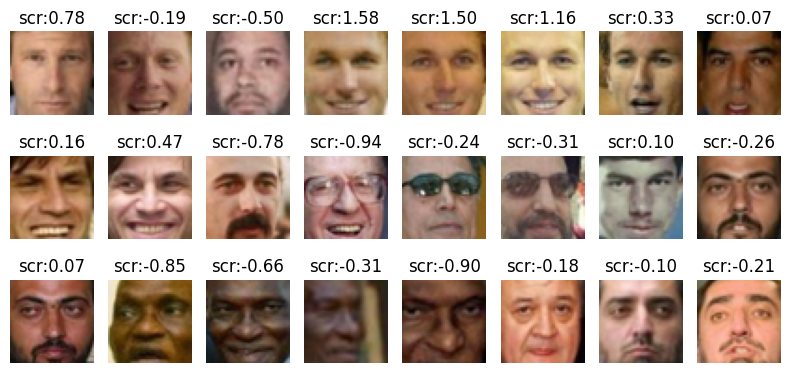

In [9]:
plt.figure(figsize=(8, 4))
for i in range(24):
    plt.subplot(3, 8, i + 1)
    plt.imshow(train_photos[i])
    plt.title(f'scr:{train_attrs["Attractive Man"][i]:.2f}')
    plt.axis("off")

plt.tight_layout()
plt.show()

In [10]:
def images_to_torch(x):
    x = x.astype('float32') / 255.0
    x = np.transpose(x, (0, 3, 1, 2))
    return x

def torch_to_images(x):
    x = np.transpose(x, (0, 2, 3, 1))
    x = (x * 255).astype("uint8")
    return x

In [9]:
def plot_epoch(train_losses, val_losses, title=None):
    plt.figure(figsize=(8, 5))
    plt.plot(np.arange(len(train_losses))+1, train_losses, label='Train')
    plt.plot(np.arange(len(val_losses))+1, val_losses, label='Validation')
    
    plt.xlabel('Epoch')
    plt.title(title)
    plt.legend()
    plt.show()

    last_train, last_val = train_losses[-1], val_losses[-1]
    print(f"""
    train_losse: {last_train}
    val_losse: {last_val}
    """)

In [11]:
train_photos, val_photos = images_to_torch(train_photos), images_to_torch(train_photos)
train_photos.shape

(11828, 3, 45, 45)

In [12]:
train_loader = torch.utils.data.DataLoader(train_photos, batch_size=32)
val_loader = torch.utils.data.DataLoader(val_photos, batch_size=32)

## 1.2. Архитектура модели (2 балла)
В этом разделе вы напишите и обучите обычный автоэнкодер.



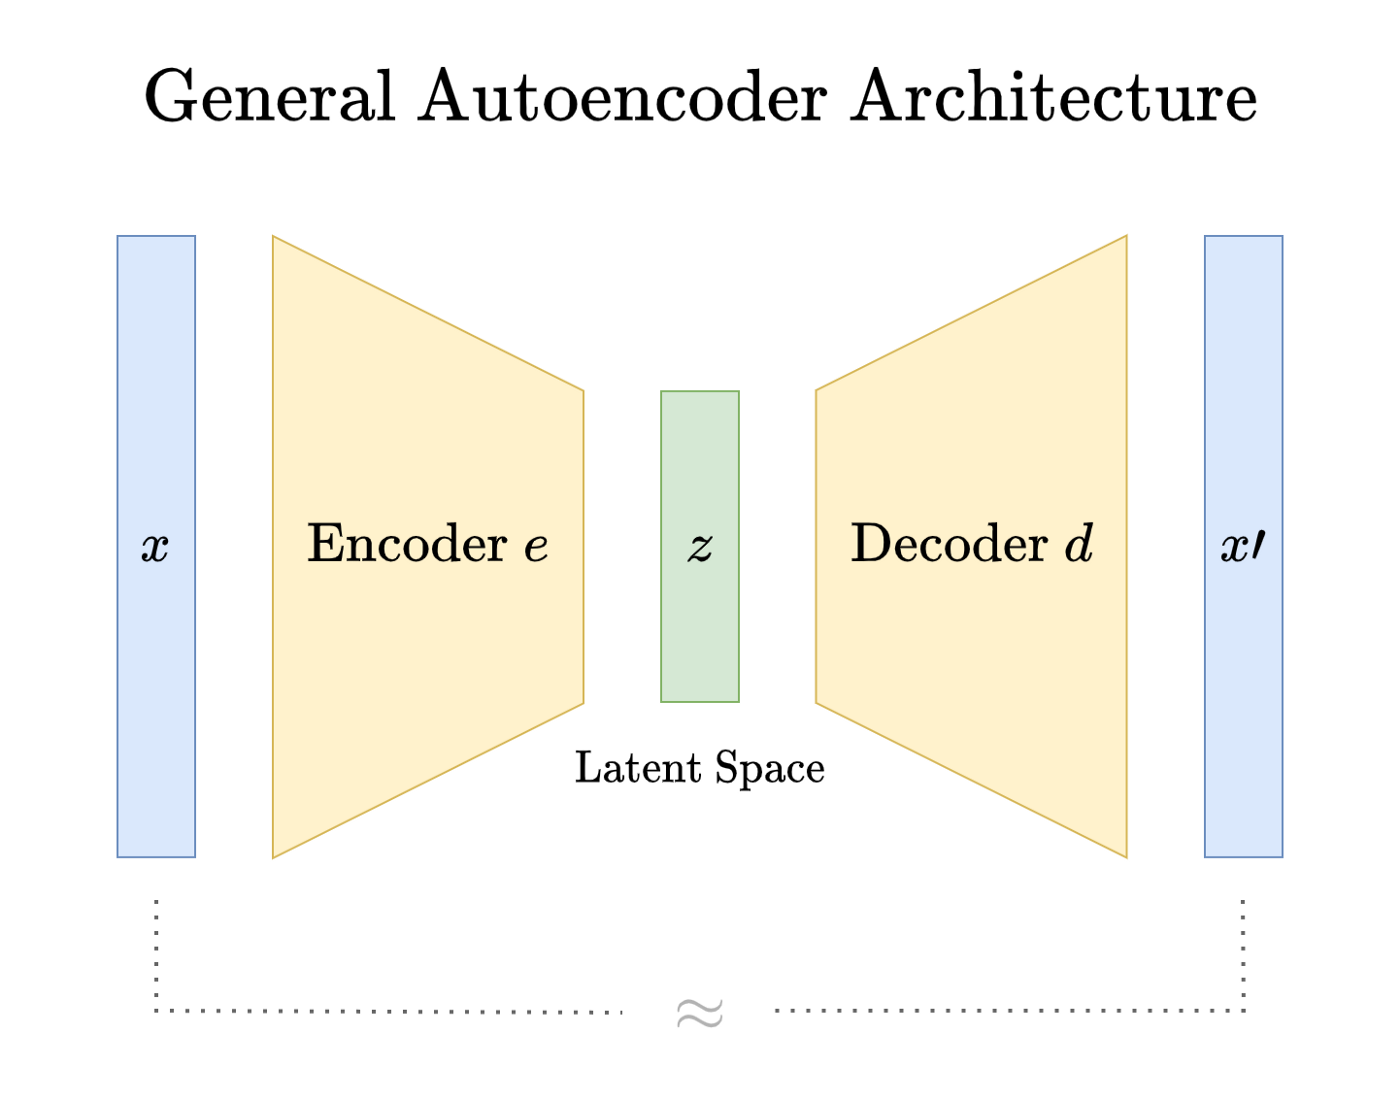

In [13]:
dim_code = 16

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [14]:
class Autoencoder(nn.Module):
  def __init__(self, dim_code=16):
    super().__init__()
    self.encoder = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=7, stride=1, padding=3), # 3 -> 32
        nn.ReLU(),
        nn.Conv2d(32, dim_code, kernel_size=7, stride=1, padding=3), # 32 -> dim_code
        nn.ReLU(),
    )
    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(dim_code, 32, kernel_size=7, stride=1, padding=3), # dim_code -> 32
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.ConvTranspose2d(32, 3, kernel_size=7, stride=1, padding=3), # 32 -> 3
    )

  def forward(self, x):
      z = self.encoder(x)
      y = self.decoder(z)
      return y, z

  def sample(self, z):
      return self.decoder(z)

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэнкодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [18]:
n_epochs = 25
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

model = Autoencoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = F.mse_loss

In [17]:
# ckpt = torch.load(f"../models/jessicali9530/Autoencoder_25_epoch.pth", map_location=device, weights_only=False)

# model.load_state_dict(ckpt['net'])
# epoch = ckpt['epoch']
# train_losses = ckpt['train_losses']
# val_losses = ckpt['val_losses']

# plot_epoch(train_losses, val_losses, f'MSE loss for {epoch} epoch')

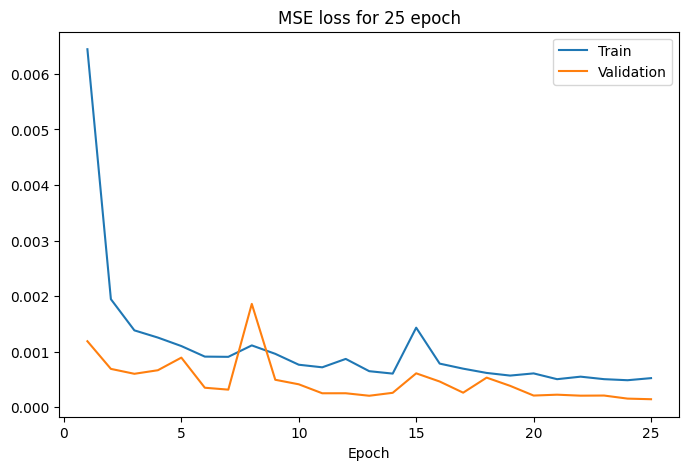


    train_losse: 0.000524712579460135
    val_losse: 0.00014529174834417455
    


In [19]:
train_losses = []
val_losses = []

for epoch in range(n_epochs):
    model.train()
    train_losses_per_epoch = []
    for i, X_batch in enumerate(train_loader):
        optimizer.zero_grad()
        reconstruction = model(X_batch.to(device))[0]
        loss = loss_fn(reconstruction, X_batch.to(device))
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0) # клип градиента
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    model.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for X_batch in val_loader:
          reconstruction = model(X_batch.to(device))[0]
          loss = loss_fn(reconstruction, X_batch.to(device))
          val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))

    clear_output(wait=True)
    plot_epoch(train_losses, val_losses, f'MSE loss for {epoch+1} epoch')

In [20]:
state = {
    'net': model.state_dict(),
    'epoch': epoch+1,
    'train_losses': train_losses,
    'val_losses': val_losses
}
torch.save(state, f"../models/jessicali9530/Autoencoder_{epoch+1}_epoch.pth")

Давайте посмотрим, как наш тренированный автоэнкодер кодирует и восстанавливает картинки:

In [21]:
model.eval()
with torch.no_grad():
    for batch in val_loader:
        reconstruction = model(batch.to(device))[0].cpu().detach().numpy()
        result = torch_to_images(reconstruction)
        ground_truth = torch_to_images(batch.numpy())
        break

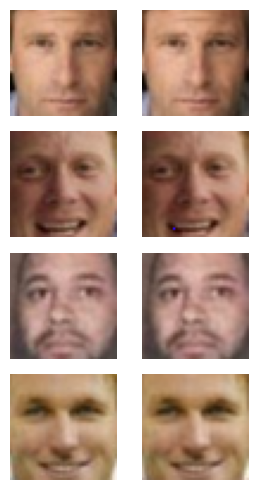

In [22]:
plt.figure(figsize=(3, 5))
for i, (gt, res) in enumerate(zip(ground_truth[:4], result[:4])):
    plt.subplot(4, 2, 2*i+1)
    plt.imshow(gt)
    plt.axis("off")
    plt.subplot(4, 2, 2*i+2)
    plt.imshow(res)
    plt.axis("off")

plt.tight_layout()
plt.show()

Что вы можете сказать про результат?

Я сравнила три обучения. Все со сверткой, первое с более простым декодером, второе с добавлением дополнительного слоя и дропаута. Хотя у более сложного декодера обучение как-будто проходило более гладко ( в первом варианте были выбросы в лоссах ), но восстановленная картинка как будто получилась даже более замыленная. В прочем они почти одинаковые и возможно я просто придумываю разницу между ними. В любом случае можно сказать что свертка практически идеально справляется. Немного не хватает шарпа на картинке, то есть восстановленная картинка слегка замылена.
В одном из туториолов я также слышала что вроде клип градиента помогает от замыленности. Поэтому я попробовала этот вариант также. И как будто бы немного стало менее замылено. Значит как-то рабоатет.

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэнкодер и получать реконструкцию, а попробуем создать что-то НОВОЕ!

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__ Если вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

In [23]:
# считаем распределение для первого батча
model.eval()
with torch.no_grad():
    for batch in val_loader:
        latents = model(batch.to(device))[1].cpu().detach()
        mu = latents.mean(dim=0) # [dim_code, 45, 45]
        sigma = latents.std(dim=0) # [dim_code, 45, 45]
        break

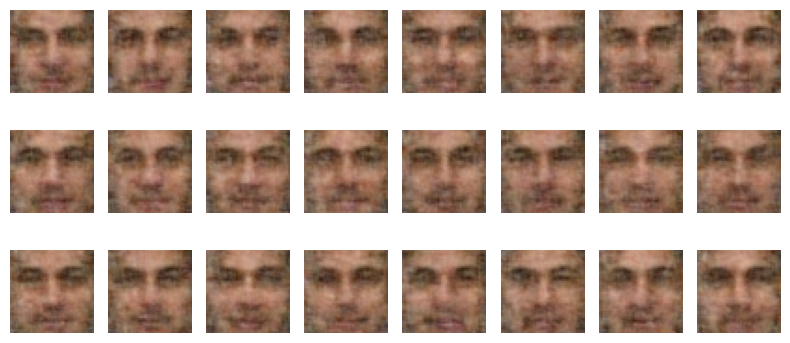

In [24]:
# сгенерируем 25 рандомных векторов размера latent_space
z = mu + sigma * torch.randn(25, dim_code, 45, 45, device=device) # [25, dim_code, 45, 45]
model.eval()
with torch.no_grad():
    sampling = model.sample(z).cpu().detach().numpy()
    
output = torch_to_images(sampling)

plt.figure(figsize=(8, 4))
for i in range(24):
    plt.subplot(3, 8, i + 1)
    plt.imshow(output[i])
    plt.axis("off")

plt.tight_layout()
plt.show()

## 1.5 Time to make fun! (3 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с атрибутами, скачанный вместе с картинками. В нем указаны имена изображений и присутствубщие атрибуты (улыбки, очки и прочее интересное).

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких.

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей.

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

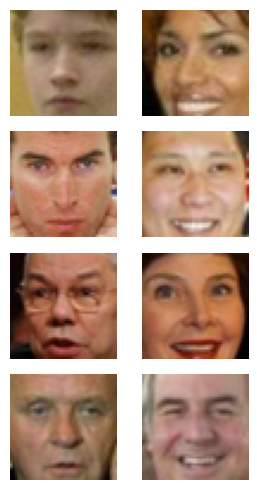

In [36]:
smile_idx = attrs['Smiling'].astype(np.float32).nlargest(500).index
unsmile_idx = attrs['Smiling'].astype(np.float32).nsmallest(500).index

plt.figure(figsize=(3, 5))
for i, (un, sm) in enumerate(zip(images[unsmile_idx][496:500], images[smile_idx][496:500])):
    plt.subplot(4, 2, 2*i+1)
    plt.imshow(un)
    plt.axis("off")
    plt.subplot(4, 2, 2*i+2)
    plt.imshow(sm)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [37]:
smile_images = torch.tensor(images_to_torch(images[smile_idx]))
unsmile_images = torch.tensor(images_to_torch(images[unsmile_idx]))

model.eval()
with torch.no_grad():
    smile_latents = model(smile_images.to(device))[1]
    unsmile_latents = model(unsmile_images.to(device))[1]

In [38]:
smile_vec = smile_latents.mean(dim=0) - unsmile_latents.mean(dim=0) # [C, H, W]
smile_vec = smile_vec.unsqueeze(0) # [1, C, 1, 1]

forced_smile_latents = unsmile_latents + smile_vec # [B, C, H, W]

model.eval()
with torch.no_grad():
    smile_reconstruction = model.sample(forced_smile_latents.to(device)).cpu().detach().numpy()

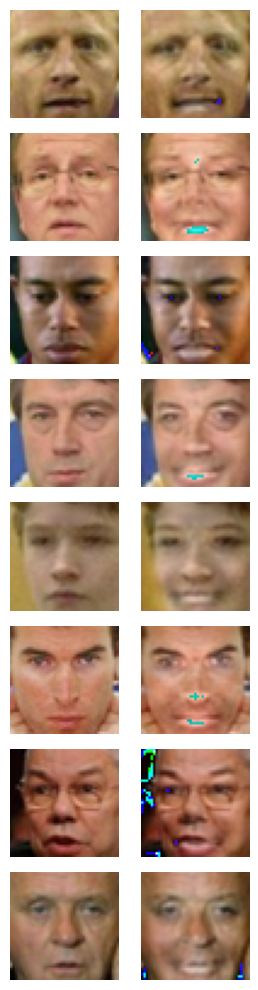

In [40]:
unsmile = torch_to_images(unsmile_images.cpu().detach().numpy())
forced_smile = torch_to_images(smile_reconstruction)

plt.figure(figsize=(3, 10))
for i, (un, sm) in enumerate(zip(unsmile[492:500], forced_smile[492:500])):
    plt.subplot(8, 2, 2*i+1)
    plt.imshow(un)
    plt.axis("off")
    plt.subplot(8, 2, 2*i+2)
    plt.imshow(sm)
    plt.axis("off")

plt.tight_layout()
plt.show()

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... В общем, все, на что хватит фантазии и на что есть атрибуты в `attrs`:)

# Часть 2: Variational Autoencoder (10 баллов)

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [3]:
batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
val_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

In [4]:
img, label = train_dataset[0]
print(img.shape, len(train_dataset))

torch.Size([1, 28, 28]) 60000


## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [22]:
class VAE(nn.Module):
    def __init__(self, features=8):
        super().__init__()
        self.features = features
        
        self.flatten = nn.Flatten()
        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, self.features*2)
        )
        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(self.features, 256),
            nn.ReLU(),
            nn.Linear(256, 784)
        )

    def encode(self, x):
        x = self.flatten(x).float()
        x = self.encoder(x).view(-1, 2, self.features)
        mu = x[:, 0, :]
        logsigma = x[:, 1, :]
        return mu, logsigma

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma) # standard deviation
            eps = torch.randn_like(std) # `randn_like` as we need the same size
            sample = mu + (eps * std) # sampling as if coming from the input space
            return sample
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu.
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu

    def decode(self, z):
        x = self.decoder(z)
        x = torch.sigmoid(x)
        reconstruction = x.view(-1, 1, 28, 28)
        return reconstruction

    def forward(self, x):
        mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu, logsigma) # латентный вектор из произвольного нормального распределения
        reconstruction = self.decode(z)
        return reconstruction, mu, logsigma

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [23]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

И обучим модель:

In [24]:
n_epochs = 25
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

criterion = loss_vae

model = VAE().to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
# ckpt = torch.load(f"../models/jessicali9530/LinearVAE_25_epoch.pth", map_location=device, weights_only=False)

# model.load_state_dict(ckpt['net'])
# epoch = ckpt['epoch']
# train_losses = ckpt['train_losses']
# val_losses = ckpt['val_losses']

# plot_epoch(train_losses, val_losses, f'VAE loss for {epoch} epoch')

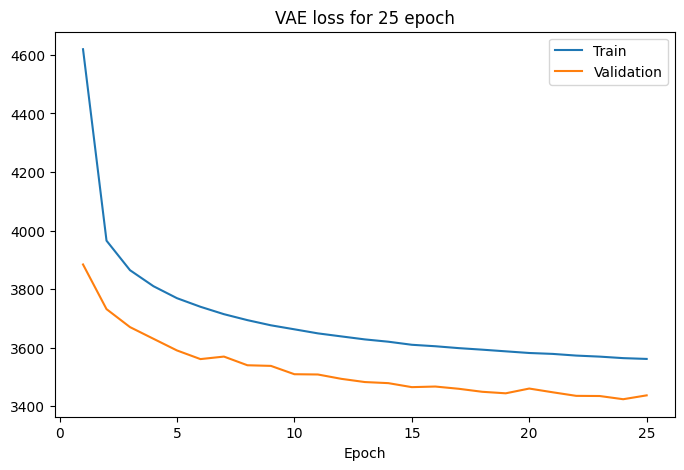


    train_losse: 3562.005884635417
    val_losse: 3437.6485712703425
    


In [25]:
train_losses = []
val_losses = []

for epoch in range(n_epochs):
    model.train()
    train_losses_per_epoch = []
    for (X_batch, _) in train_loader:
        optimizer.zero_grad()
        reconstruction, mu, logsigma = model(X_batch.to(device))
        loss = criterion(X_batch.to(device).float(), mu, logsigma, reconstruction)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())
    
    train_losses.append(np.mean(train_losses_per_epoch))
    
    model.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for (X_batch, _) in val_loader:
            reconstruction, mu, logsigma = model(X_batch.to(device))
            loss = criterion(X_batch.to(device).float(), mu, logsigma, reconstruction)
            val_losses_per_epoch.append(loss.item())
    
    val_losses.append(np.mean(val_losses_per_epoch))
    
    clear_output(wait=True)
    plot_epoch(train_losses, val_losses, f'VAE loss for {epoch+1} epoch')

In [26]:
state = {
    'net': model.state_dict(),
    'epoch': epoch+1,
    'train_losses': train_losses,
    'val_losses': val_losses
}
torch.save(state, f"../models/jessicali9530/LinearVAE_{epoch+1}_epoch.pth")

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

In [27]:
model.eval()
with torch.no_grad():
    for (batch, _) in val_loader:
        reconstruction = model(batch.to(device))[0].cpu().detach().numpy()
        ground_truth = batch.numpy()
        break

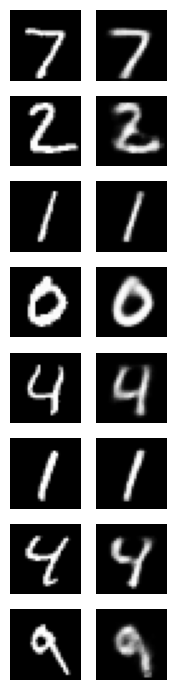

In [28]:
plt.figure(figsize=(2, 7))
for i, (gt, res) in enumerate(zip(ground_truth[:8], reconstruction[:8])):
    plt.subplot(8, 2, 2*i+1)
    plt.imshow(gt.squeeze(0), cmap='gray')
    plt.axis("off")
    plt.subplot(8, 2, 2*i+2)
    plt.imshow(res.squeeze(0), cmap='gray')
    plt.axis("off")

plt.tight_layout()
plt.show()

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

In [29]:
model.eval()
with torch.no_grad():
    for (batch, _) in val_loader:
        reconstruction, mu, logsigma = model(batch.to(device))
        break

z = mu.mean(dim=0) + logsigma.mean(dim=0) * torch.randn(100, 8, device=device)
model.eval()
with torch.no_grad():
    output = model.decode(z.float()).cpu().detach().numpy()

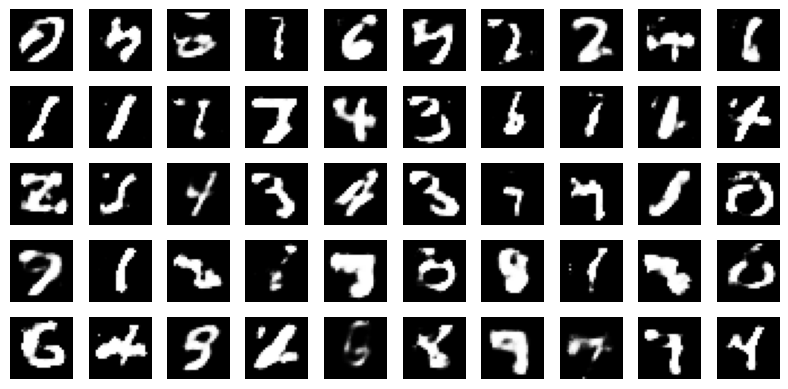

In [30]:
plt.figure(figsize=(8, 4))
for i in range(50):
    plt.subplot(5, 10, i + 1)
    plt.imshow(output[i].squeeze(0), cmap='gray')
    plt.axis("off")

plt.tight_layout()
plt.show()

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве.

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве.

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

In [17]:
latents = []
labels = []

model.eval()
with torch.no_grad():
    for batch, labels in val_loader:
        mu = model(batch.to(device))[1]
        latents.append(mu.cpu().numpy())
        labels.append(labels.numpy())

latents = np.concatenate(latents, axis=0)
labels = np.concatenate(labels, axis=0)

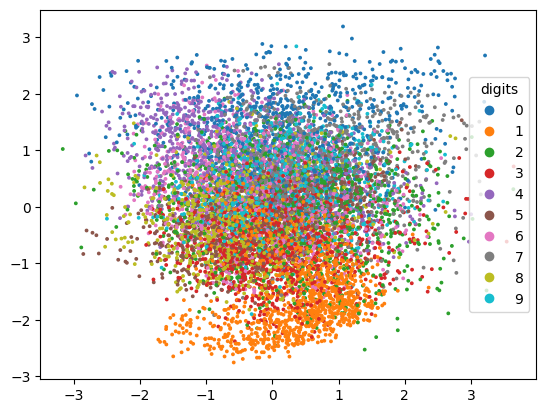

In [21]:
z = latents[:, :2]

scatter = plt.scatter(z[:,0], z[:,1], c=labels, s=3, cmap='tab10')
plt.legend(*scatter.legend_elements(), title="digits", loc="right")
plt.show()

Что вы думаете о виде латентного представления?

Почему-то мне казалось что они должны были быть сильнее разнесены в пространстве друго от друга. Хотя некоторая диференцированность имеет место быть. Например интересно что `0` и `1` максимально отстоят друг от друга. Ну и действительно они максимально не похожи. А `0` с `6` стоят довольно близко.

__Congrats v2.0!__

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер.
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица).
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки.

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [38]:
class CVAE(nn.Module):
    def __init__(self, features=8, class_num=10):
        super().__init__()
        self.features = features
        self.class_num = class_num
        
        self.flatten = nn.Flatten()
        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(784+self.class_num, 256),
            nn.ReLU(),
            nn.Linear(256, self.features*2)
        )
        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(self.features+self.class_num, 256),
            nn.ReLU(),
            nn.Linear(256, 784)
        )

    def encode(self, x, labels):
        x = self.flatten(x).float()
        x = torch.cat([x, labels], dim=1)
        z = self.encoder(x)
        z = z.view(-1, 2, self.features)
        mu = z[:, 0, :]
        logsigma = z[:, 1, :]
        return mu, logsigma

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma) # standard deviation
            eps = torch.randn_like(std) # `randn_like` as we need the same size
            sample = mu + (eps * std) # sampling as if coming from the input space
            return sample
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu.
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu

    def decode(self, z, labels):
        z = torch.cat([z, labels], dim=1)
        x = self.decoder(z)
        x = torch.sigmoid(x)
        reconstruction = x.view(-1, 1, 28, 28)
        return reconstruction

    def forward(self, x, labels):
        mu, logsigma = self.encode(x, labels)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z, labels)
        return reconstruction, mu, logsigma

In [39]:
n_epochs = 25
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

criterion = loss_vae

model = CVAE().to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
# ckpt = torch.load(f"../models/jessicali9530/CVAE_25_epoch.pth", map_location=device, weights_only=False)

# model.load_state_dict(ckpt['net'])
# epoch = ckpt['epoch']
# train_losses = ckpt['train_losses']
# val_losses = ckpt['val_losses']

# plot_epoch(train_losses, val_losses, f'VAE loss for {epoch} epoch')

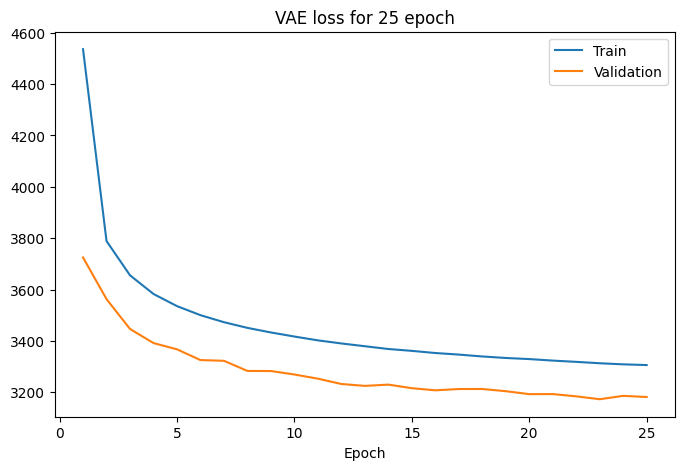


    train_losse: 3305.8359759114583
    val_losse: 3181.4219296001397
    


In [42]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(sparse_output=False)
labels = train_dataset.targets.numpy()

enc.fit(labels.reshape(-1,1))

train_losses = []
val_losses = []

for epoch in range(n_epochs):
    model.train()
    train_losses_per_epoch = []
    for (X_batch, labels) in train_loader:
        labels = enc.transform(labels.reshape(-1,1))
        labels = torch.tensor(labels).float()
        optimizer.zero_grad()
        reconstruction, mu, logsigma = model(X_batch.to(device), labels.to(device))
        loss = criterion(X_batch.to(device).float(), mu, logsigma, reconstruction)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())
    
    train_losses.append(np.mean(train_losses_per_epoch))
    
    model.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for (X_batch, labels) in val_loader:
            labels = enc.transform(labels.reshape(-1,1))
            labels = torch.tensor(labels).float()
            reconstruction, mu, logsigma = model(X_batch.to(device), labels.to(device))
            loss = criterion(X_batch.to(device).float(), mu, logsigma, reconstruction)
            val_losses_per_epoch.append(loss.item())
    
    val_losses.append(np.mean(val_losses_per_epoch))
    
    clear_output(wait=True)
    plot_epoch(train_losses, val_losses, f'VAE loss for {epoch+1} epoch')

In [43]:
state = {
    'net': model.state_dict(),
    'epoch': epoch+1,
    'train_losses': train_losses,
    'val_losses': val_losses
}
torch.save(state, f"../models/jessicali9530/CVAE_{epoch+1}_epoch.pth")

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

In [47]:
model.eval()
with torch.no_grad():
    for (batch, labels) in val_loader:
        labels = enc.transform(labels.reshape(-1,1))
        labels = torch.tensor(labels).float()
        reconstruction, mu, logsigma = model(batch.to(device), labels.to(device))
        break

z = mu.mean(dim=0) + logsigma.mean(dim=0) * torch.randn(100, 8, device=device)

labels5 = torch.full((100, 1), 5)
labels5 = enc.transform(labels5)
labels5 = torch.tensor(labels5).float()

labels7 = torch.full((100, 1), 7)
labels7 = enc.transform(labels7)
labels7 = torch.tensor(labels7).float()

model.eval()
with torch.no_grad():
    output5 = model.decode(z.float(), labels5.to(device)).cpu().detach().numpy()
    output7 = model.decode(z.float(), labels7.to(device)).cpu().detach().numpy()

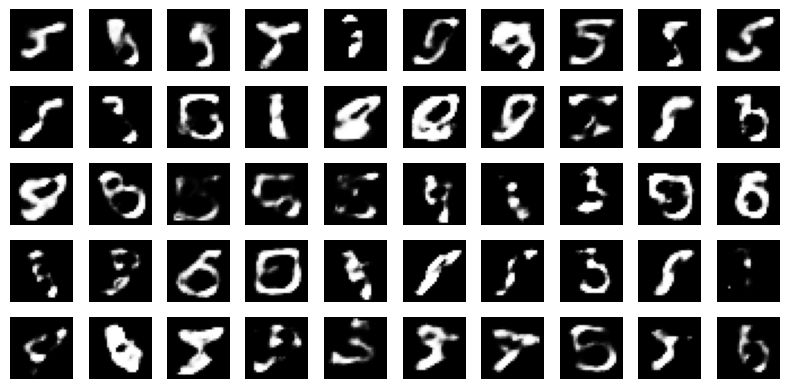

In [53]:
plt.figure(figsize=(8, 4))
for i in range(50):
    plt.subplot(5, 10, i + 1)
    plt.imshow(output5[i].squeeze(0), cmap='gray')
    plt.axis("off")

plt.tight_layout()
plt.show()

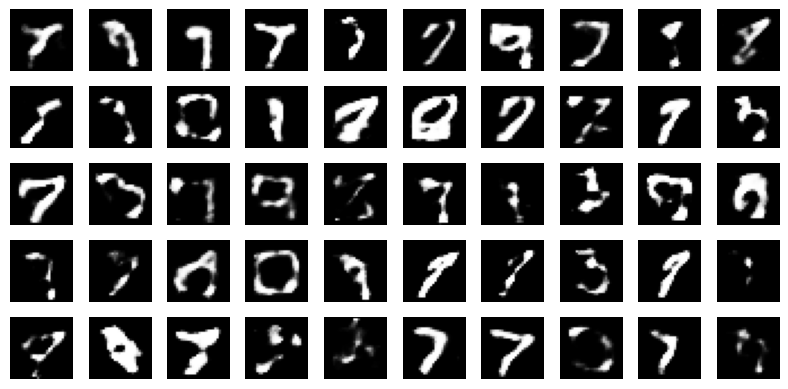

In [49]:
plt.figure(figsize=(8, 4))
for i in range(50):
    plt.subplot(5, 10, i + 1)
    plt.imshow(output7[i].squeeze(0), cmap='gray')
    plt.axis("off")

plt.tight_layout()
plt.show()

Splendid! Вы великолепны!


### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [55]:
latents = []
num_labels = []

model.eval()
with torch.no_grad():
    for batch, labels in val_loader:
        onehot_labels = enc.transform(labels.reshape(-1,1))
        onehot_labels = torch.tensor(onehot_labels).float()
        mu = model(batch.to(device), onehot_labels.to(device))[1]
        latents.append(mu.cpu().numpy())
        num_labels.append(labels.numpy())

latents = np.concatenate(latents, axis=0)
num_labels = np.concatenate(num_labels, axis=0)

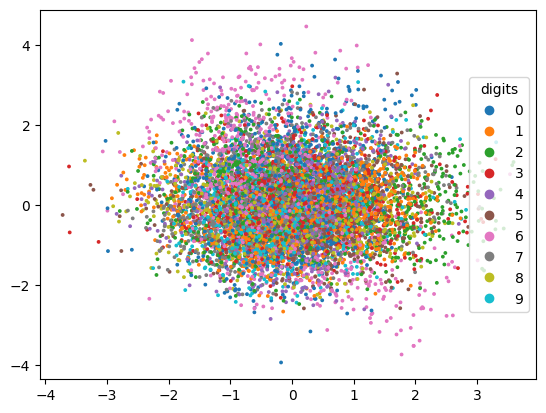

In [56]:
z = latents[:, :2]

scatter = plt.scatter(z[:,0], z[:,1], c=num_labels, s=3, cmap='tab10')
plt.legend(*scatter.legend_elements(), title="digits", loc="right")
plt.show()

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

Ну я бы сказала что она несколько ближе к нормальному распределению чем чистое VAE, соотвественно все классы еще более перемешены между собой и глазами их уже невозможно диференциировать. Они прямо полностью все перемешаны в одном пространстве, почти что рандомно.

Нету сил уже на бонусы, очень много времени заняла эта домашка, перехожу к следующей.

# BONUS 1: Denoising (2 балла)

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них эта бонусная часть задания.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума.
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для этого нужно взять ваш любимый датасет (датасет лиц из первой части этого задания или любой другой) и сделать копию этого датасета с шумом.

В питоне шум можно добавить так:

In [ ]:
noise_factor = 0.5
X_noisy = X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X.shape)

In [ ]:
<тут ваш код обучения автоэнкодера на зашумленных картинках. Не забудьте разбить на train/test!>

In [ ]:
<тут проверка, как AE убирает шум с тестовых картинок. Надеюсь, все получилось =)>

# BONUS 2: Image Retrieval (2 балла)

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентных представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest `(sklearn.neighbors.LSHForest)`, например, с `n_estimators=50`
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [ ]:
codes = <поучите латентные представления картинок из трейна>

In [ ]:
# обучаем LSHForest
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes)

In [ ]:
def get_similar(image, n_neighbors=5):
  # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
  # прогоняет векторы через декодер и получает картинки ближайших людей

  code = <получение латентного представления image>

  (distances,),(idx,) = lshf.kneighbors(code, n_neighbors=n_neighbors)

  return distances, X_train[idx]

In [ ]:
def show_similar(image):

  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат

    distances,neighbors = get_similar(image,n_neighbors=11)

    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")

    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

In [ ]:
<тут выведите самые похожие лица к какому-нибудь лицу из тестовой части датасета>